**HOW MUCH DOES AGE AND PLAYED HOURS INFLUENCE SUBSCRIPTION RATE?**

In [78]:
library(tidyverse)
library(tidymodels)

**Introduction**:

Our data originates from a research group from the Computer Science department at UBC investigating how individuals play video games. We have acquired data from a MineCraft server, where players’ actions were recorded as they explored a new world. Our task is to assist the research group in recruitment efforts and resource (software licenses and server hardware) management.

We have been handed two datasets: players.csv and sessions.csv. We have chosen to explore the players.csv, which is described below:

In [79]:
player_data <- "https://raw.githubusercontent.com/rinhatan/dsci100_project/refs/heads/main/players.csv"
players <- read_csv(player_data)
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


This dataset includes information regarding an individual’s gaming experience (Beginner, Amateur, Regular, Pro, or Veteran), whether or not they have subscribed to a game-related newspaper, their hashed email, the number of hours they have played on the MineCraft server, their name, their gender, and their age. However, not all of these variables are useful or properly formatted for our data analysis. For example, the `gender` and `Age` variables have missing or uninformative values (i.e., ‘Prefer not to say’ or ‘NA’), which can be removed. Moreover, several variables have incorrect data types, which must be changed.


Our goal is to aid in the research group’s recruitment efforts, so the overarching question we will attempt to tackle is presented below.

**Question 1:** What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

To better answer this question and effectively explore the dataset, we have determined a sub-question to aid our analysis.

**Sub-Question:** Is player age and played hours both influencial variables that predict subscription rate?

We believe this question answers our overarching question as our exploratory variables are the individual’s age and number of played hours, which we hope will predict whether they subscribe to the gaming newsletter. We will aim to explore whether younger/older players or how long they spend on the MineCraft server influence their subscription rates. If there is a trend, resources may be prioritized for individuals with these behaviours to maximize subscription rates.


**METHOD AND RESULTS**

----------- INCLUDE METHODS USED HERE ----------

In [94]:
player_whole <- players |>
            select(played_hours, Age, subscribe) |>
            mutate(subscribe = as_factor(subscribe)) |>
            mutate(subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE"))

----------- INCLUDE SUMMARY OF DATA SET ----------

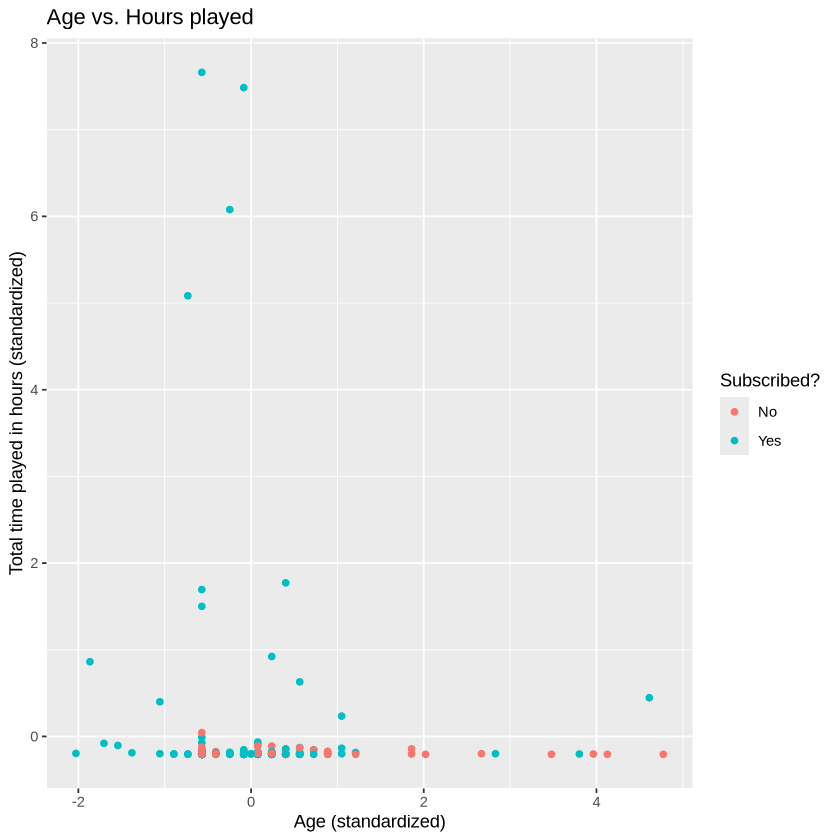

In [104]:
players_first_recipe <- recipe(subscribe ~ Age + played_hours, data = player_whole) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_impute_mean(all_predictors()) |>
    prep()
scaled_players <- bake(players_first_recipe, player_whole)

player_summary <- scaled_players |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point() +
    labs(x = "Age (standardized)", y = "Total time played in hours (standardized)", color = "Subscribed?") +
    ggtitle("Age vs. Hours played")
player_summary

**DATA ANALYSIS:**

In [45]:
set.seed(1)
player_split <- initial_split(player_whole, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

**For analyzing the data accuracy of Age:**

[1] 31

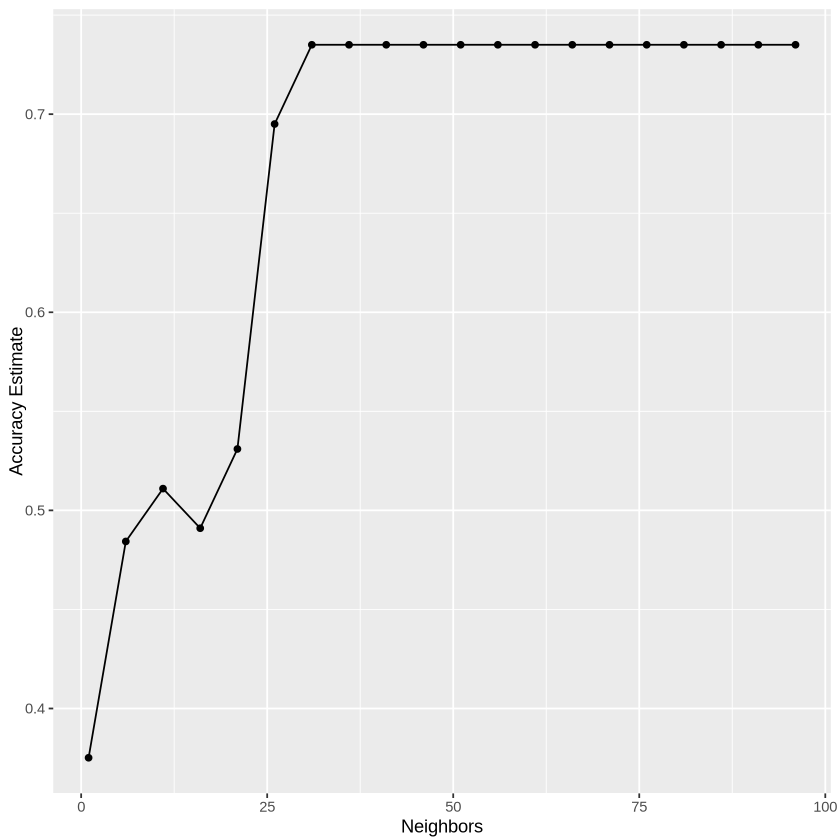

In [108]:
k_vals_age <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

player_vfold_age <- vfold_cv(player_train, v = 10, strata = subscribe)

knn_spec_age <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |>
    set_mode("classification")

player_recipe_age <- recipe(subscribe ~ Age, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_impute_mean(all_predictors())

knn_results_age <- workflow() |>
    add_recipe(player_recipe_age) |>
    add_model(knn_spec_age) |>
    tune_grid(resamples = player_vfold_age, grid = k_vals_age) |>
    collect_metrics()

accuracy_find_age <- knn_results_age |>
    filter(.metric == "accuracy")

accuracy_vs_k_lots_age <- ggplot(accuracy_find_age, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")

best_k_age <- accuracy_find_age |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

best_k_age
accuracy_vs_k_lots_age

In [113]:
player_recipe_2 <- recipe(subscribe ~ Age, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_age) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit_2 <- workflow() |>
    add_recipe(player_recipe_2) |>
    add_model(knn_spec_2) |>
    fit(data = player_train)

player_test_predictions_age <- predict(knn_fit_2, player_test) |>
    bind_cols(player_test)

player_test_accuracy_age <- player_test_predictions_age |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

player_test_accuracy_age

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


**For analyzing the data accuracy of played hours:**

[1] 51

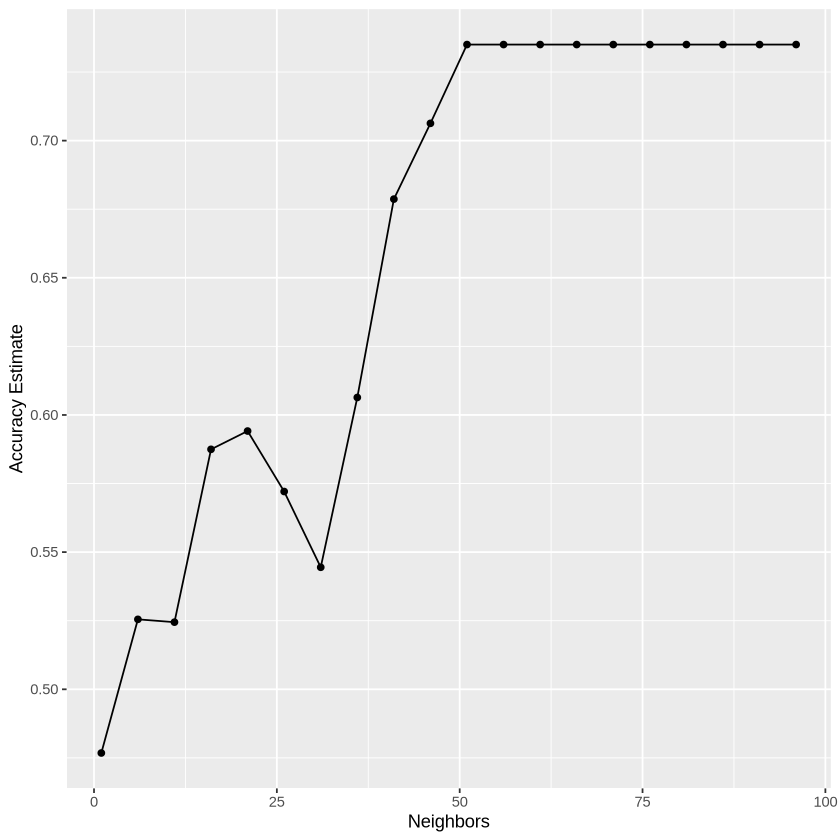

In [83]:
k_vals_hours <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

player_vfold_hours <- vfold_cv(player_train, v = 10, strata = subscribe)

knn_spec_hours <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |>
    set_mode("classification")

player_recipe_hours <- recipe(subscribe ~ played_hours, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_impute_mean(all_predictors())

knn_results_hours <- workflow() |>
    add_recipe(player_recipe_hours) |>
    add_model(knn_spec_hours) |>
    tune_grid(resamples = player_vfold_hours, grid = k_vals_hours) |>
    collect_metrics()

accuracy_find_hours <- knn_results_hours |>
    filter(.metric == "accuracy")

accuracy_vs_k_lots_hours <- ggplot(accuracy_find_hours, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")

best_k_hours <- accuracy_find_hours |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

best_k_hours
accuracy_vs_k_lots_hours

In [89]:
player_recipe_3 <- recipe(subscribe ~ played_hours, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec_3 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k_hours) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit_3 <- workflow() |>
    add_recipe(player_recipe_3) |>
    add_model(knn_spec_3) |>
    fit(data = player_train)

player_test_predictions_hours <- predict(knn_fit_3, player_test) |>
    bind_cols(player_test)

player_test_accuracy_hours <- player_test_predictions_hours |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

player_test_accuracy_hours

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5510204


**For both played hours and age:**

[1] 21

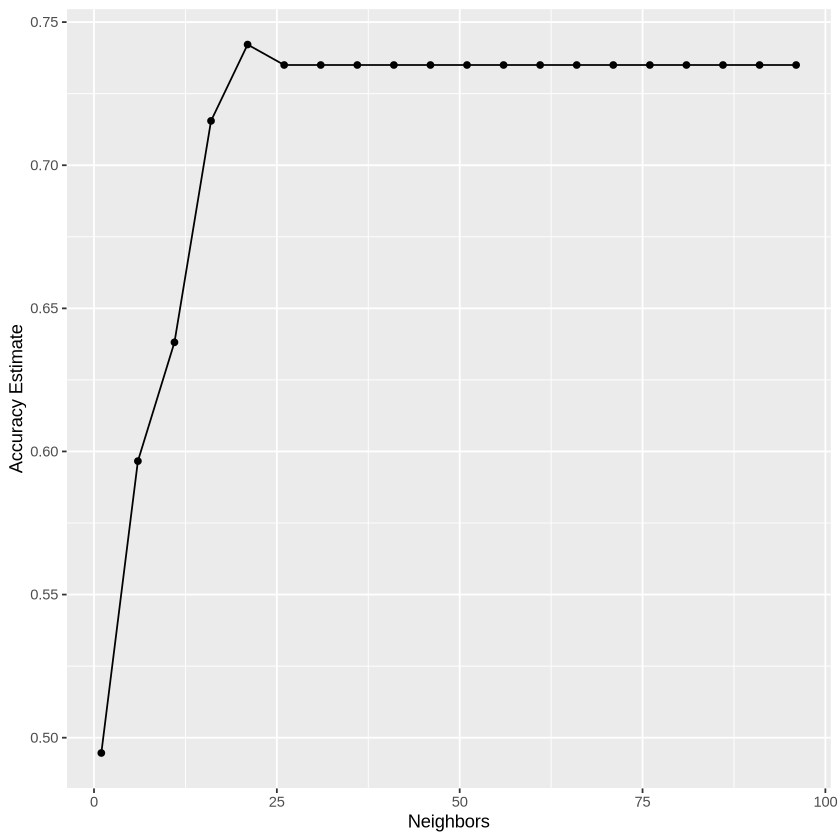

In [110]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

player_vfold <- vfold_cv(player_train, v = 10, strata = subscribe)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
    set_engine("kknn") |>
    set_mode("classification")

player_recipe <- recipe(subscribe ~ Age + played_hours, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_impute_mean(all_predictors())

knn_results <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = player_vfold, grid = k_vals) |>
    collect_metrics()

accuracy_find <- knn_results |>
    filter(.metric == "accuracy")

accuracy_vs_k_lots <- ggplot(accuracy_find, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")

best_k <- accuracy_find |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

best_k
accuracy_vs_k_lots

In [111]:
player_recipe_2 <- recipe(subscribe ~ Age + played_hours, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec_2 <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit_2 <- workflow() |>
    add_recipe(player_recipe_2) |>
    add_model(knn_spec_2) |>
    fit(data = player_train)

player_test_predictions <- predict(knn_fit_2, player_test) |>
    bind_cols(player_test)

player_test_accuracy <- player_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

player_test_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857


**Overall, the results were:**

In [114]:
player_test_accuracy_age
player_test_accuracy_hours
player_test_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5510204


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7142857


New names:
• `` -> `...5`


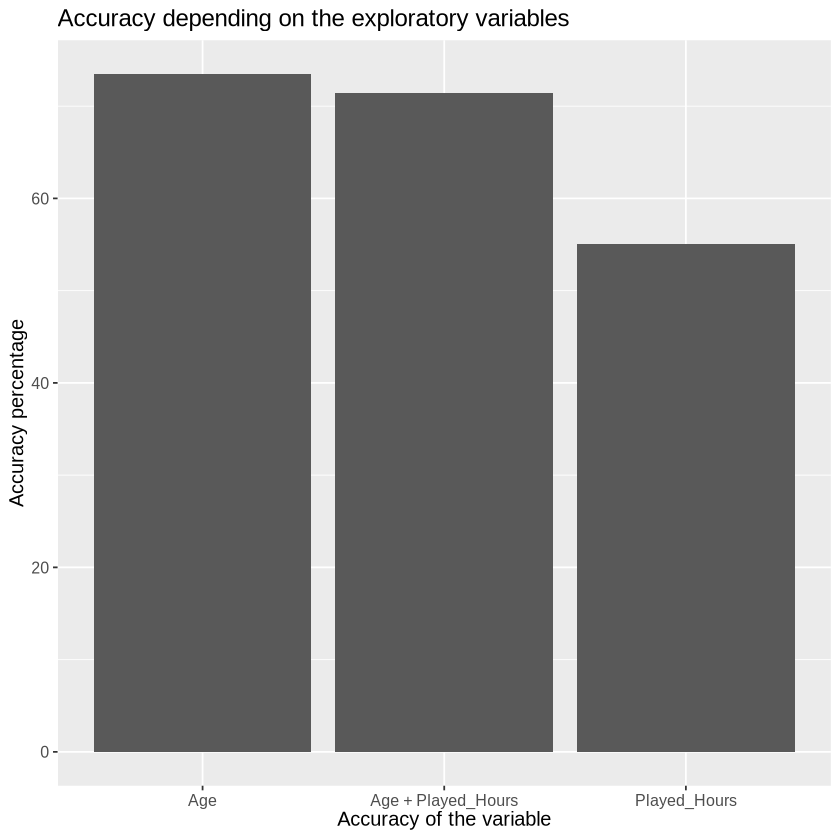

In [130]:
types <- c("Age", "Played_Hours", "Age + Played_Hours")
final_table <- bind_rows(player_test_accuracy_age, player_test_accuracy_hours, player_test_accuracy) |>
            mutate(accuracy = .estimate * 100) |>
            bind_cols(types) |>
            rename(Accuracy_Types = ...5)
            
final_plot <- ggplot(final_table, aes(x = Accuracy_Types, y = accuracy)) +
            geom_bar(stat = "identity") +
            labs(x = "Accuracy of the variable", y = "Accuracy percentage") +
            theme(text = element_text(size = 12)) +
            ggtitle("Accuracy depending on the exploratory variables")
final_plot

**Discussion**